In [20]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import rasterio
from rasterio.sample import sample_gen
from rasterio.enums import Resampling

# Charger le fichier Excel (nécessite le module 'openpyxl')
file_path = r'D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\Athabasca\roverRS+\Rover\rover_athabasca.xlsx'
df = pd.read_excel(file_path, engine='openpyxl')

# Renommer la colonne '%' pour éviter les problèmes
df.rename(columns={'%': 'percent'}, inplace=True)

# Convertir certaines colonnes en type numérique
columns_to_convert = ['latitude', 'longitude', 'height', 'ns', 'sdn(m)', 'sde(m)', 'sdu(m)', 'sdne(m)', 'sdeu(m)', 'sdun(m)', 'age(s)', 'ratio']
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Vérifier les colonnes du DataFrame
print(df.columns)

# Supposons que les colonnes 'latitude' et 'longitude' existent dans le fichier
latitude_col = 'latitude'
longitude_col = 'longitude'

# Créer une géométrie de points à partir des colonnes de latitude et longitude
df['geometry'] = df.apply(lambda row: Point(row[longitude_col], row[latitude_col]), axis=1)

# Convertir en GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Supprimer les colonnes de type non compatible pour éviter les erreurs avec le shapefile
columns_to_drop = ['percent']  # Ajouter d'autres colonnes si nécessaire
gdf.drop(columns=columns_to_drop, inplace=True)

# Définir le système de coordonnées (par exemple, WGS84)
gdf.set_crs(epsg=4326, inplace=True)

# Spécifier le répertoire de sortie pour sauvegarder le shapefile
output_dir = r'D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\Athabasca\roverRS+\Rover'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'rover_athabasca.shp')

# Sauvegarder en tant que shapefile (limiter les noms de colonnes à 10 caractères)
gdf.columns = [col[:10] for col in gdf.columns]
gdf.to_file(output_path, driver='ESRI Shapefile')

print("Conversion en shapefile terminée avec succès.")

# Charger le shapefile généré
gdf = gpd.read_file(output_path)

# Convertir le fichier .tif en float 32 bits
dem_path = r"D:\UQTR\Automne 2024\Ouest\SRTM\SRTM_DEM_corrected6.tif"
dem_float32_path = r"D:\UQTR\Automne 2024\Ouest\SRTM\SRTM_DEM_corrected6_float32.tif"

# Ouvrir et convertir le .tif en float 32 bits
with rasterio.open(dem_path) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32)

    with rasterio.open(dem_float32_path, 'w', **profile) as dst:
        for i in range(1, src.count + 1):
            data = src.read(i, resampling=Resampling.nearest).astype(rasterio.float32)
            dst.write(data, i)

# Charger le DEM converti
with rasterio.open(dem_float32_path) as dem:
    # Extraire la hauteur du DEM pour chaque point du shapefile
    coords = [(x, y) for x, y in zip(gdf.geometry.x, gdf.geometry.y)]
    gdf['dem_heigh'] = [val[0] for val in dem.sample(coords)]

# Calculer la différence entre la hauteur mesurée et la hauteur du DEM
gdf['heigh_diff'] = gdf['height'] - gdf['dem_heigh']

# Sauvegarder le GeoDataFrame mis à jour (limiter les noms de colonnes à 10 caractères)
gdf.columns = [col[:10] for col in gdf.columns]
gdf.to_file(output_path, driver='ESRI Shapefile')

print("Extraction des données de hauteur du DEM et calcul de la différence terminés avec succès.")

Index(['percent', 'GPST', 'latitude', 'longitude', 'height', 'Q', 'ns',
       'sdn(m)', 'sde(m)', 'sdu(m)', 'sdne(m)', 'sdeu(m)', 'sdun(m)', 'age(s)',
       'ratio'],
      dtype='object')
Conversion en shapefile terminée avec succès.
Extraction des données de hauteur du DEM et calcul de la différence terminés avec succès.


C:\Users\thier\AppData\Local\Temp\ipykernel_39444\3537236777.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  {'geometry': [gdf_sorted.geometry.unary_union.convex_hull]},


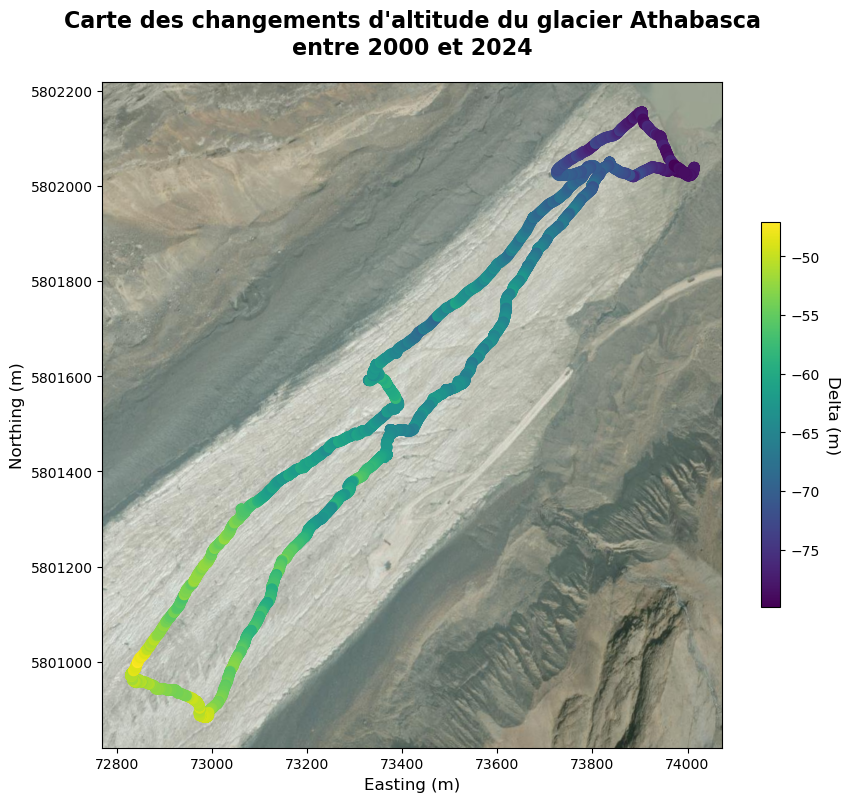

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Charger le fichier shapefile
# Le chemin d'accès au fichier shapefile contenant les données des points GNSS
gdf = gpd.read_file(r'D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\Athabasca\roverRS+\Rover\rover_athabasca.shp')

# Convertir les points en lignes
# Trier les points par une colonne qui peut représenter l'ordre de la ligne, par exemple 'GPST' (données GPS temporelles)
gdf_sorted = gdf.sort_values('GPST')

# Créer une ligne à partir des points triés
# Utiliser 'unary_union' pour fusionner tous les points en une seule géométrie, puis prendre l'enveloppe convexe (convex hull) pour créer une ligne
# Cela est utile pour avoir une représentation générale des points en tant que ligne
gdf_line = gpd.GeoDataFrame(
    {'geometry': [gdf_sorted.geometry.unary_union.convex_hull]},
    crs=gdf.crs
)

# Créer une carte graduée pour représenter les changements d'altitude
# Reprojeter les données dans le système de coordonnées UTM (par exemple, EPSG:32612 pour UTM zone 12N)
gdf_sorted = gdf_sorted.to_crs(epsg=32612)

# Initialiser la figure et les axes pour la carte
fig, ax = plt.subplots(figsize=(10, 10))

# Tracer les lignes et utiliser la colonne 'heigh_diff' pour la couleur
# Représenter les différences d'altitude en utilisant un dégradé de couleurs (cmap='viridis')
gdf_sorted.plot(ax=ax, column='heigh_diff', cmap='viridis', legend=True, linewidth=2, legend_kwds={'shrink': 0.5})

# Ajouter une légende qui spécifie le delta en mètre
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Delta (m)', rotation=270, labelpad=15, fontsize=12)

# Ajouter une basemap satellite pour donner un contexte géographique
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=gdf_sorted.crs, attribution="")
# Convertir les ticks des axes en coordonnées UTM
ax.set_xlabel("Easting (m)", fontsize=12)  # Étiquette de l'axe X en UTM avec taille de police
ax.set_ylabel("Northing (m)", fontsize=12)  # Étiquette de l'axe Y en UTM avec taille de police
ax.ticklabel_format(useOffset=False, style='plain')  # Désactiver le décalage et afficher les coordonnées en style normal

# Afficher la carte avec le titre
plt.title("Carte des changements d'altitude du glacier Athabasca\nentre 2000 et 2024", fontsize=16, fontweight='bold', pad=20)
plt.show()

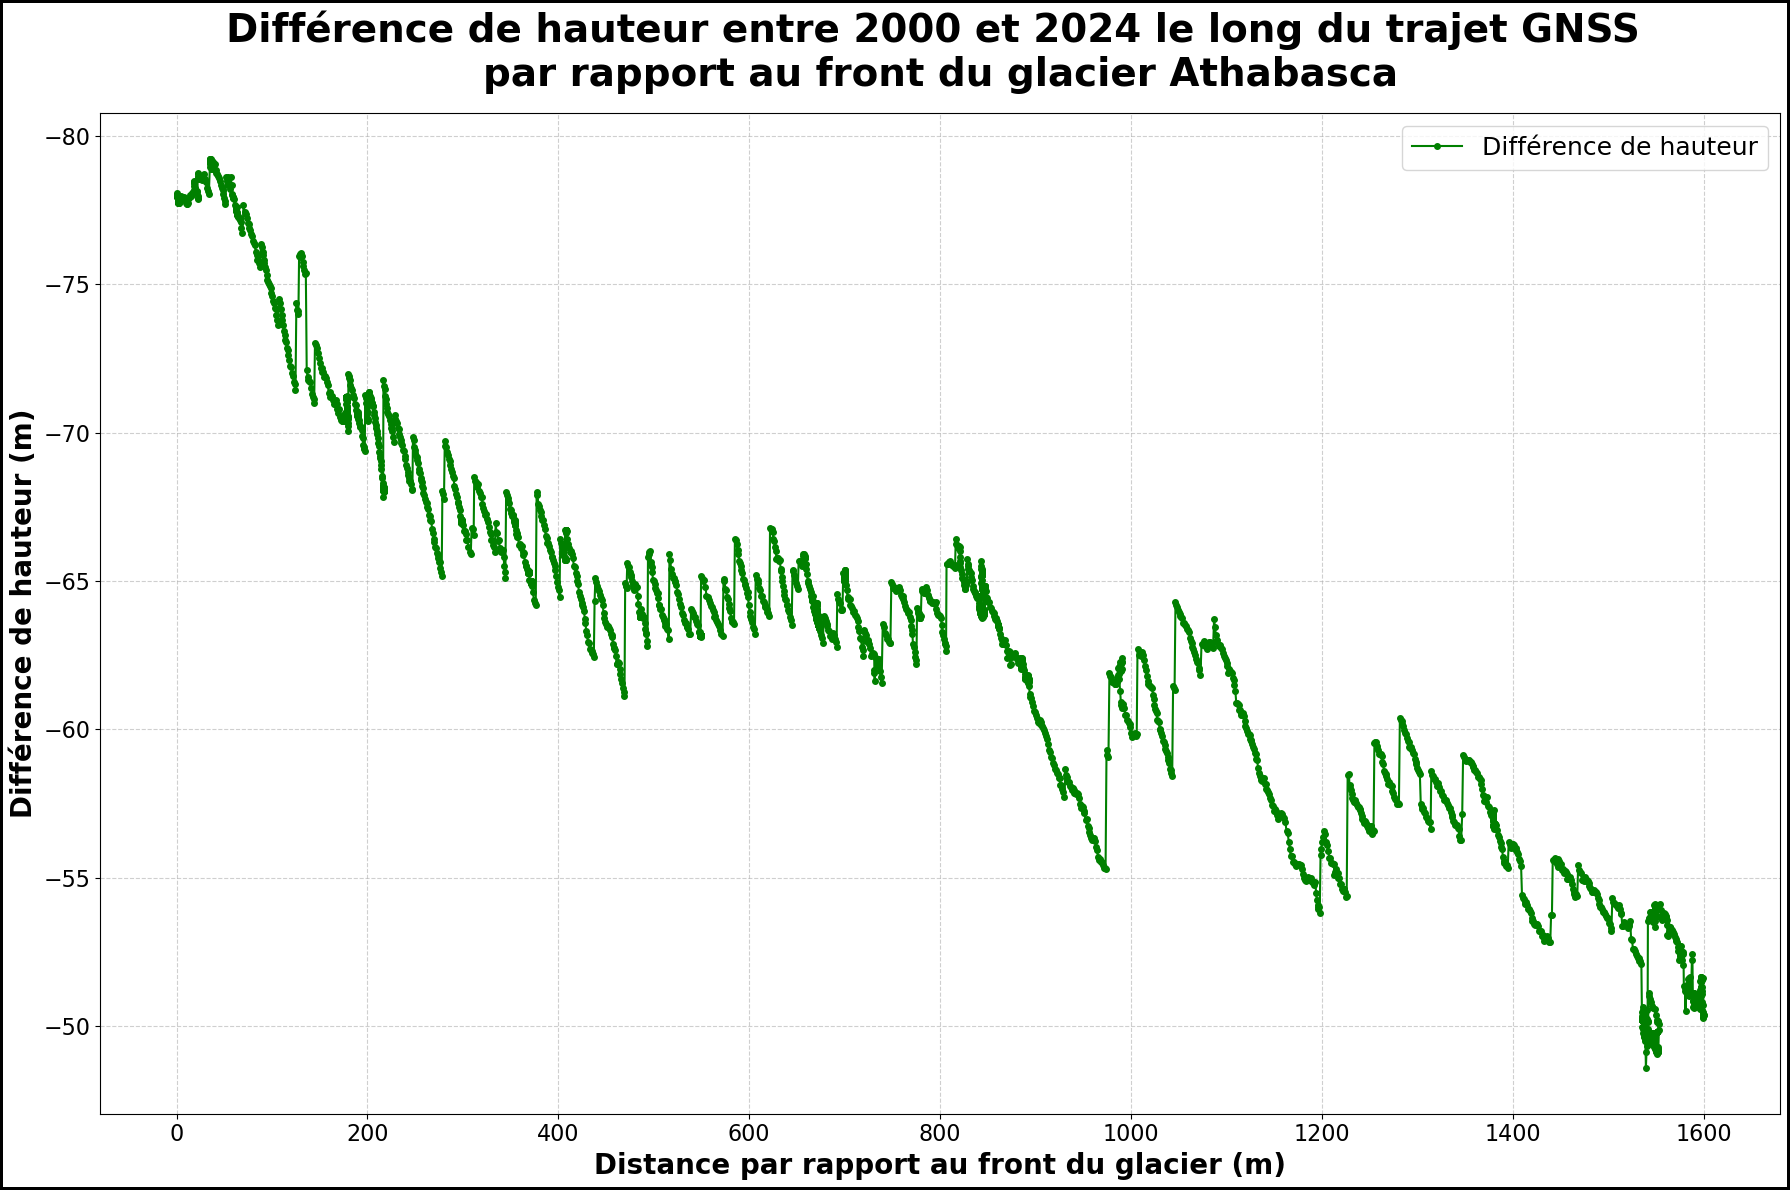

In [108]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer
from matplotlib.patches import Rectangle

# Charger le fichier shapefile
gdf = gpd.read_file(r'D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\Athabasca\roverRS+\Rover\rover_athabasca.shp')

# Trier les points par une colonne qui peut représenter l'ordre de la ligne, par exemple 'GPST' (données GPS temporelles)
gdf_sorted = gdf.sort_values('GPST')

# Transformer les coordonnées en UTM (zone 12N, par exemple EPSG:32612)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32612", always_xy=True)
gdf_sorted['utm_x'], gdf_sorted['utm_y'] = transformer.transform(gdf_sorted.geometry.x, gdf_sorted.geometry.y)

# Calculer la distance cumulative entre les points
gdf_sorted['distance'] = np.sqrt((gdf_sorted['utm_x'].diff()**2) + (gdf_sorted['utm_y'].diff()**2))
gdf_sorted['distance_cumulative'] = gdf_sorted['distance'].cumsum().fillna(0)

# Calculer la distance par rapport au front du glacier (point avec id 0)
front_x = gdf_sorted.iloc[0]['utm_x']
front_y = gdf_sorted.iloc[0]['utm_y']
gdf_sorted['distance_from_front'] = np.sqrt((gdf_sorted['utm_x'] - front_x)**2 + (gdf_sorted['utm_y'] - front_y)**2)

# Assurer que les colonnes 'height1' et 'height2' sont présentes
gdf_sorted['height1'] = gdf_sorted['height']
gdf_sorted['height2'] = gdf_sorted['dem_heigh']

# Calculer la différence de hauteur
gdf_sorted['height_diff'] = gdf_sorted['height2'] - gdf_sorted['height1']

# Filtrer les points jusqu'à l'ID 5191 (distance maximale atteinte par le glacier)
gdf_filtered = gdf_sorted.iloc[:5192]

# Tracer le graphique représentant la différence de hauteur en fonction de la distance par rapport au front du glacier
fig, ax = plt.subplots(figsize=(18, 12))

# Tracer la différence de hauteur en négatif
ax.plot(gdf_filtered['distance_from_front'], -gdf_filtered['height_diff'], label='Différence de hauteur', color='g', linestyle='-', marker='o', markersize=4)

# Ajouter des labels et un titre au graphique avec une police plus grande
ax.set_xlabel('Distance par rapport au front du glacier (m)', fontsize=20, fontweight='bold')
ax.set_ylabel('Différence de hauteur (m)', fontsize=20, fontweight='bold')
ax.set_title('Différence de hauteur entre 2000 et 2024 le long du trajet GNSS \npar rapport au front du glacier Athabasca', fontsize=28, fontweight='bold', pad=20)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=18, loc='best')

# Augmenter la police des ticks
ax.tick_params(axis='both', which='major', labelsize=16)

# Inverser l'axe des y pour avoir une échelle décroissante
ax.invert_yaxis()

# Ajouter une bordure noire autour du layout sans changer la taille du layout
fig.patch.set_linewidth(3)
fig.patch.set_edgecolor('black')

plt.tight_layout()
plt.savefig('height_difference_plot.png', dpi=300)
plt.show()


In [ ]:
gdf_sorted

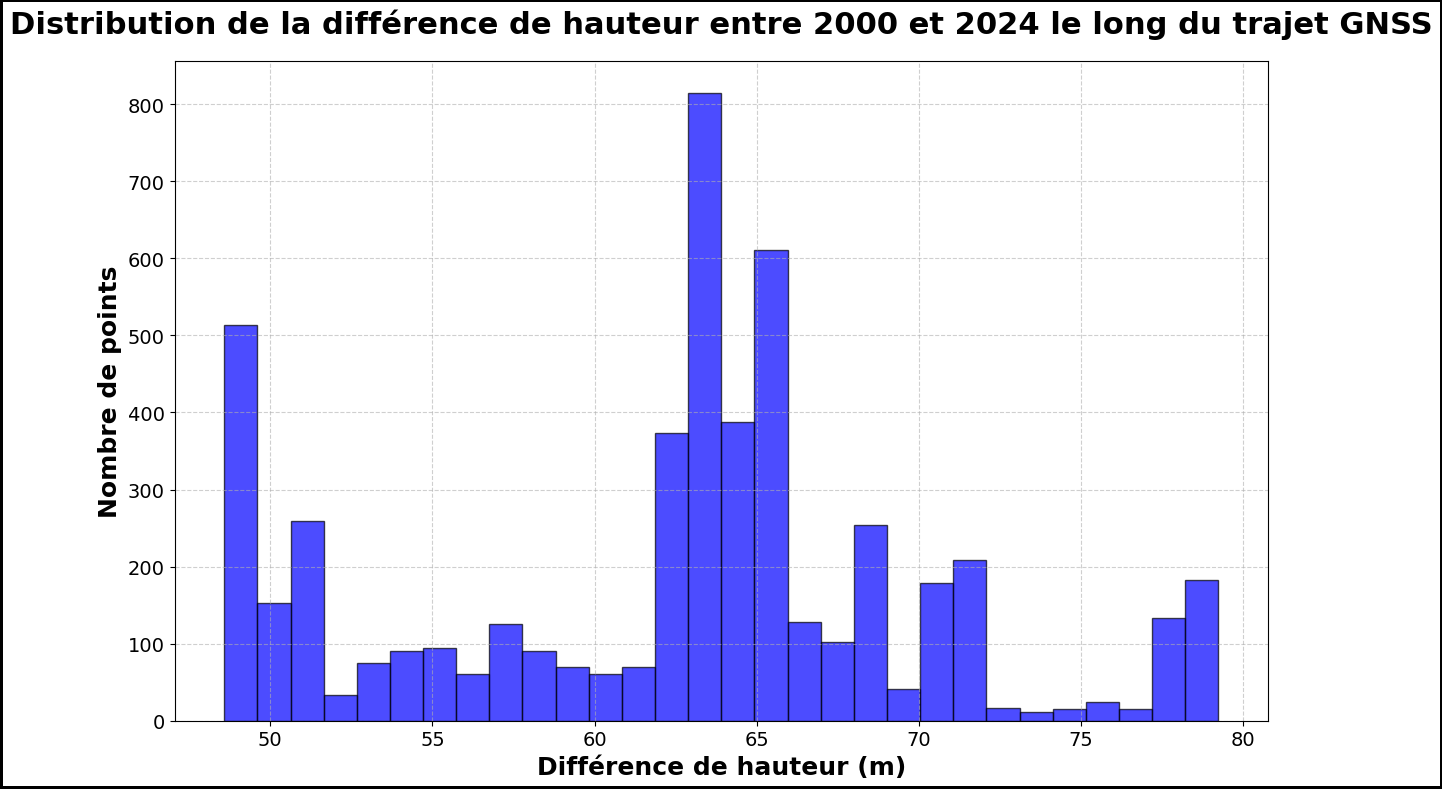

In [9]:
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer
from matplotlib.patches import Rectangle

# Charger le fichier shapefile
gdf = gpd.read_file(r'D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\Athabasca\roverRS+\Rover\rover_athabasca.shp')

# Trier les points par une colonne qui peut représenter l'ordre de la ligne, par exemple 'GPST' (données GPS temporelles)
gdf_sorted = gdf.sort_values('GPST')

# Transformer les coordonnées en UTM (zone 12N, par exemple EPSG:32612)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32612", always_xy=True)
gdf_sorted['utm_x'], gdf_sorted['utm_y'] = transformer.transform(gdf_sorted.geometry.x, gdf_sorted.geometry.y)

# Calculer la distance cumulative entre les points
gdf_sorted['distance'] = np.sqrt((gdf_sorted['utm_x'].diff()**2) + (gdf_sorted['utm_y'].diff()**2))
gdf_sorted['distance_cumulative'] = gdf_sorted['distance'].cumsum().fillna(0)

# Calculer la distance par rapport au front du glacier (point avec id 0)
front_x = gdf_sorted.iloc[0]['utm_x']
front_y = gdf_sorted.iloc[0]['utm_y']
gdf_sorted['distance_from_front'] = np.sqrt((gdf_sorted['utm_x'] - front_x)**2 + (gdf_sorted['utm_y'] - front_y)**2)

# Assurer que les colonnes 'height1' et 'height2' sont présentes
gdf_sorted['height1'] = gdf_sorted['height']
gdf_sorted['height2'] = gdf_sorted['dem_heigh']

# Calculer la différence de hauteur
gdf_sorted['height_diff'] = gdf_sorted['height2'] - gdf_sorted['height1']

# Filtrer les points jusqu'à l'ID 5191 (distance maximale atteinte par le glacier)
gdf_filtered = gdf_sorted.iloc[:5192]

# Tracer l'histogramme de la différence de hauteur
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(gdf_filtered['height_diff'], bins=30, color='blue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Différence de hauteur (m)', fontsize=18, fontweight='bold')
ax.set_ylabel('Nombre de points', fontsize=18, fontweight='bold')
ax.set_title('Distribution de la différence de hauteur entre 2000 et 2024 le long du trajet GNSS', fontsize=22, fontweight='bold', pad=20)
ax.grid(True, linestyle='--', alpha=0.6)

# Augmenter la police des ticks
ax.tick_params(axis='both', which='major', labelsize=14)

# Ajouter une bordure noire autour du layout sans changer la taille du layout
fig.patch.set_linewidth(3)
fig.patch.set_edgecolor('black')

plt.tight_layout()
plt.savefig('height_difference_histogram.png', dpi=300)
plt.show()


In [19]:
import pandas as pd

# Calculer les statistiques descriptives pour les hauteurs mesurées, les hauteurs DEM, et la différence de hauteur
gdf_filtered['height_diff'] = gdf_filtered['height2'] - gdf_filtered['height1']
stats_descriptive = gdf_filtered[['height1', 'height2', 'height_diff']].describe()

# Créer un DataFrame pour représenter les statistiques descriptives
data = {
    "Statistique": ["Nombre (count)", "Moyenne (mean)", "Écart-type (std)", "Minimum (min)", "25% Quartile", "Médiane (50%)", "75% Quartile", "Maximum (max)"],
    "Height1 (m)": [
        stats_descriptive.loc['count', 'height1'],
        stats_descriptive.loc['mean', 'height1'],
        stats_descriptive.loc['std', 'height1'],
        stats_descriptive.loc['min', 'height1'],
        stats_descriptive.loc['25%', 'height1'],
        stats_descriptive.loc['50%', 'height1'],
        stats_descriptive.loc['75%', 'height1'],
        stats_descriptive.loc['max', 'height1']
    ],
    "Height2 (m)": [
        stats_descriptive.loc['count', 'height2'],
        stats_descriptive.loc['mean', 'height2'],
        stats_descriptive.loc['std', 'height2'],
        stats_descriptive.loc['min', 'height2'],
        stats_descriptive.loc['25%', 'height2'],
        stats_descriptive.loc['50%', 'height2'],
        stats_descriptive.loc['75%', 'height2'],
        stats_descriptive.loc['max', 'height2']
    ],
    "Height Diff (m)": [
        stats_descriptive.loc['count', 'height_diff'],
        stats_descriptive.loc['mean', 'height_diff'],
        stats_descriptive.loc['std', 'height_diff'],
        stats_descriptive.loc['min', 'height_diff'],
        stats_descriptive.loc['25%', 'height_diff'],
        stats_descriptive.loc['50%', 'height_diff'],
        stats_descriptive.loc['75%', 'height_diff'],
        stats_descriptive.loc['max', 'height_diff']
    ]
}

stats_table_df = pd.DataFrame(data)

# Générer le tableau des statistiques descriptives en format Markdown
markdown_table = stats_table_df.to_markdown(index=False)

# Sauvegarder le tableau en Markdown dans un fichier
with open(r'D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\statistiques_descriptives_tableau.md', 'w') as file:
    file.write(markdown_table)

# Afficher le tableau en Markdown
print(markdown_table)

| Statistique      |   Height1 (m) |   Height2 (m) |   Height Diff (m) |
|:-----------------|--------------:|--------------:|------------------:|
| Nombre (count)   |     5192      |     5192      |        5192       |
| Moyenne (mean)   |     2051.69   |     2114.04   |          62.3447  |
| Écart-type (std) |       50.3974 |       43.0858 |           7.81822 |
| Minimum (min)    |     1961.51   |     2040      |          48.582   |
| 25% Quartile     |     2009.02   |     2074      |          56.8527  |
| Médiane (50%)    |     2049.88   |     2115      |          63.6422  |
| 75% Quartile     |     2100.8    |     2160      |          66.0163  |
| Maximum (max)    |     2120.74   |     2172      |          79.2283  |


c:\Users\thier\miniforge3\envs\geospatial_env\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
